<a href="https://colab.research.google.com/github/Kaidavid/ml_for_molecules/blob/main/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Install Miniconda and RDKit

#Install miniconda
!wget -c https://repo.continuum.io/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh
!chmod +x Miniconda3-py37_4.8.3-Linux-x86_64.sh
!time bash ./Miniconda3-py37_4.8.3-Linux-x86_64.sh -b -f -p /usr/local

# Install RDKit
!time conda install -q -y -c conda-forge rdkit==2020.09.2
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

--2022-06-06 07:30:19--  https://repo.continuum.io/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.200.79, 104.18.201.79, 2606:4700::6812:c94f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.200.79|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh [following]
--2022-06-06 07:30:19--  https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.130.3, 104.16.131.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.130.3|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

PREFIX=/usr/local
Unpacking payload ...
Solving environment: / - \ | / - \ | / - \ | / - \ | fail

In [ ]:
!conda install -c conda-forge deepchem
!conda install transformers

Solving environment: \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / done

# All requested packages already installed.

Solving environment: / - \ | / - \ | / - \ | / - \ | / - \ | / - done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - transformers


The following packages will be SUPERSEDED by a higher-priority channel:

  ca-certificates    conda-forge::ca-certificates-2022.5.1~ --> pkgs/main::ca-certificates-2022.4.26-h06a4308_0
  certifi            conda-forge::certifi-2022.5.18.1-py37~ --> pkgs/main::certifi-2022.5.18.1-py37h06a4308_0
  conda              conda-forge::conda-4.13.0-py37h89c186~ --> pkgs/main::conda-4.13.0-py37h06a4308_0
  openssl            conda-forge::openssl-1.1.1o-h166bdaf_0 --> pkgs/main::openssl-1.1.1o-h7f8727e_0


Proceed ([y]/n)? y

Preparing transaction: | done
Verifying transaction: - \ don

In [ ]:
#@title Check whether RDKit is successfully installed.
import rdkit
print("rdkit is successfully installed!")

rdkit is successfully installed!


In [ ]:
import os
from google.colab import drive

drive.mount('/gdrive')

root = '/gdrive/My Drive/CBE591/AE_practice'
os.chdir(root)
os.getcwd()

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


'/gdrive/My Drive/CBE591/AE_practice'

In [ ]:
import numpy as np
import sys
import json

import math
import glob
import functools

import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as grad
from torch.autograd import Variable
from torch.nn.parameter import Parameter
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ExponentialLR

from deepchem.feat.smiles_tokenizer import BasicSmilesTokenizer
from rdkit import Chem

import time
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
name = 'data/All_Training_Smiles.smi'

lines = open(name).readlines()

tokenizer = BasicSmilesTokenizer()
tokens = []
max_len = 0
for smi in lines:
    temp = tokenizer.tokenize(smi)
    token = list(set(temp))
    tokens.extend(token)
    if len(temp) > max_len:
        max_len = len(temp)
char_list = list(set(tokens))
char_list.extend(["<", ">"])

In [ ]:
vocabulary = dict(zip(char_list, [i for i in range(len(char_list))]))

In [ ]:
tokenized_smiles = []
for smi in lines:
    tokenized_smi = [str(vocabulary["<"])] + [str(vocabulary[token]) for token in tokenizer.tokenize(smi)]
    tokenized_smi = tokenized_smi + [str(vocabulary[">"])]*(max_len + 2 - len(tokenized_smi))
    joined = ", ".join(tokenized_smi) + "\n"
    tokenized_smiles.append(joined)

In [ ]:
np.random.seed(1)
np.random.shuffle(lines)

train_data = tokenized_smiles[:int(0.8*len(tokenized_smiles))]
val_data = tokenized_smiles[int(0.8*len(tokenized_smiles)):int(0.9*len(tokenized_smiles))]
test_data = tokenized_smiles[int(0.9*len(tokenized_smiles)):]

print('Split Data...')
train_name, val_name, test_name = 'data/my_Train_Smiles.txt', 'data/my_Val_Smiles.txt', 'data/my_Test_Smiles.txt'

open(train_name, 'w').writelines(train_data)
open(val_name, 'w').writelines(val_data)
open(test_name, 'w').writelines(test_data)

Split Data...


In [ ]:
class RNN_VAE(nn.Module):
  def __init__(self):
    super(RNN_VAE,self).__init__()
    self.n_vocab = 50   #50 # 73
    self.dim_emb = 50   #50 # 73
    self.n_layer = 1
    self.dim_h = 512
    self.direct = 1
    self.dim_z = 256
    self.in_len = 51    #51
    self.emb = nn.Embedding(self.n_vocab,self.dim_emb)

    # encoder part
    self.gru_encoder = nn.GRU(input_size = self.dim_emb, hidden_size = self.dim_h,batch_first = True)

    self.z_fc = nn.Sequential(
          nn.Linear(self.dim_h,self.dim_h,bias=False),
          # nn.BatchNorm1d(self.dim_h),
          nn.ReLU(),
          # nn.Dropout(0.2),
          nn.Linear(self.dim_h,self.dim_h,bias=False),
          # nn.BatchNorm1d(self.dim_h),
          nn.ReLU(),
          # nn.Dropout(0.2)
          )  #, nn.Linear(self.dim_h,self.dim_z,bias=False))

    # decoder part
    self.z_to_h0 = nn.Linear(self.dim_z,self.dim_h,bias=False)
    self.dim_y = self.dim_emb + self.dim_z
    self.gru_decoder = nn.GRU(input_size = self.dim_y, hidden_size = self.dim_h,batch_first = True)
    self.x_fc = nn.Sequential(
          nn.Linear(self.dim_h,self.dim_h,bias=False),
          nn.ReLU(),
          # nn.Dropout(0.2),
          nn.Linear(self.dim_h,self.dim_h,bias=False),
          nn.ReLU(),
          # nn.Dropout(0.2),
          nn.Linear(self.dim_h,self.n_vocab,bias=False)
          )
    
    self.mean_ = nn.Linear(self.dim_h, self.dim_z, bias=False)
    self.var_ = nn.Linear(self.dim_h, self.dim_z, bias=False)

  def forward(self,x1,x2):  #x1: index for encoder (No start token) // x2: index for decoder (No end token)
    # encoder part
    x_emb1 = self.emb(x1)
    x1s = x1.size(0)
    B = x_emb1.size(0)
    h0_e = torch.zeros(self.n_layer*self.direct,B,self.dim_h)
    h0_e = self.get_var(h0_e)
    out,h1_e = self.gru_encoder(x_emb1,h0_e)
    h_e = h1_e.view(self.n_layer,B,self.dim_h)[-1].view(B,self.dim_h)
    # z = self.z_fc(h_e).view(-1,self.dim_z)
    
    # added
    z = self.z_fc(h_e)
    z_mean = self.mean_(h_e).view(-1, self.dim_z)
    z_log_var = self.var_(h_e).view(-1, self.dim_z)
    epsilon = self.get_var(torch.normal(mean=0.0, std=1.0, size=(B, self.dim_z)))
    z = z_mean + torch.exp(0.5 * z_log_var) * epsilon
    z = z.view(-1, self.dim_z)


    # decoder part // Teacher forcing
    x_emb2 = self.emb(x2)
    B = x_emb2.size(0)
    nc = x_emb2.size(1)
    zh_ = z.view(1,B,self.dim_z).repeat(self.n_layer,1,1)
    h0_d = self.z_to_h0(zh_)

    z_ = z.view(B,1,self.dim_z).repeat(1,nc,1)
    x_in = torch.cat([x_emb2,z_],dim=2)
    out,h1_d = self.gru_decoder(x_in,h0_d)
    x_out = self.x_fc(out).view(-1,self.n_vocab)
    return x_out, z_mean, z_log_var

  def get_var(self,v):
    return Variable(v.cuda())
      
      
  def sampling(self,inputs,max_len=50,start_token_num=48):  # 73 56
    #decoder part
    inputs = self.get_var(inputs)
    B = inputs.size(0)
    nc = inputs.size(1)
    hidden = self.z_to_h0(inputs)
    h0_d = hidden.view(1,B,self.dim_h).repeat(self.n_layer,1,1)

    z_ = inputs.view(B,1,self.dim_z).repeat(1,max_len,1)
    z_ = self.get_var(z_)
    ones = start_token_num*torch.ones(B,1).long()
    ones = self.get_var(ones)

    output = []

    for i in range(max_len):
        start_token = self.emb(ones.view(B,1))
        x_in = torch.cat([start_token,z_[:,i,:].view(B,1,-1)],dim=2)
        x_in = self.get_var(x_in)
        out,h1_d = self.gru_decoder(x_in,h0_d)
        x_out = self.x_fc(out).view(-1,self.n_vocab)
        pred = x_out.view(B,1,self.n_vocab)
        ones = torch.argmax(pred,2)
        h0_d = h1_d
        output.append(ones)

    return torch.cat(output, dim=1)

In [ ]:
class UserDataset(Dataset):
  def __init__(self, datadir, name):
      lines = open(os.path.join(datadir,name)).readlines()
      self.len = len(lines)
      X = []
      for ll in tqdm(lines):
          X.append([int(kk) for kk in ll.split(',')])
      self.X = torch.tensor(X)

  def __getitem__(self,index):
      return self.X[index]

  def __len__(self):
      return self.len

In [ ]:
batch_size = 200
num_epoch = 50

save_dir = 'VAE_Log/practice_VAE/'
    
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

MolVAE = RNN_VAE().cuda()

tr_dataset = UserDataset('','data/Train_Smiles.txt')
val_dataset = UserDataset('','data/Val_Smiles.txt')

trainloader = DataLoader(tr_dataset,batch_size=batch_size,shuffle=True)
valloader = DataLoader(val_dataset,batch_size=batch_size,shuffle=False)

ce_loss = nn.CrossEntropyLoss()
# kl_loss = nn.L1Loss(reduction='sum')

optim_VAE = optim.Adam(MolVAE.parameters(),lr=0.001)

100%|██████████| 4330/4330 [00:00<00:00, 94793.21it/s]


In [ ]:
def train(k):
    MolVAE.train()
    L1 = 0; L2 = 0; Acc = 0; Ntot = 0;
    for inputs in tqdm(trainloader):
        Inds = Variable(inputs.view(-1,51).cuda())    # 74
        xout, z_mean, z_log_var = MolVAE(Inds[:,1:], Inds[:,:-1])
        CL = ce_loss(xout, Inds[:,1:].reshape(-1))  #   reconstruction loss
        # Ltot = CL
        batch_size = Inds.size(0)
        Ntot += batch_size
        
        L1 += batch_size * CL.cpu().detach().numpy()
        
        KL = 1 + z_log_var - torch.square(z_mean) - torch.exp(z_log_var)
        KL = torch.mean(KL)
        L2 += batch_size * KL.cpu().detach().numpy()
        KL *= -0.5

        Ltot = CL + k*KL
        optim_VAE.zero_grad()
        Ltot.backward()
        optim_VAE.step()

    return L1/Ntot, L2/Ntot, Ltot

def validation(k):
    MolVAE.eval()
    L1 = 0; L2 = 0; Acc = 0; Ntot = 0;
    for inputs in tqdm(valloader):
        Inds = Variable(inputs.view(-1,51).cuda())
        xout, z_mean, z_log_var = MolVAE(Inds[:,1:], Inds[:,:-1])
        CL = ce_loss(xout,Inds[:,1:].reshape(-1))
        # Ltot = CL
        xx = torch.argmax(xout,1).reshape(-1,50)
        ids = Inds[:,1:]
        accs = np.mean(torch.sum(xx==ids,1).cpu().detach().numpy())/50.0
        batch_size = Inds.size(0)
        Acc += batch_size * accs
        Ntot += batch_size
        L1 += batch_size * CL.cpu().detach().numpy()
        
        KL = 1 + z_log_var - torch.square(z_mean) - torch.exp(z_log_var)
        KL = torch.mean(KL)
        L2 += batch_size * KL.cpu().detach().numpy()
        KL *= -0.5

        Ltot = CL + k*KL

    return L1/Ntot, L2/Ntot, Ltot, Acc/Ntot

In [ ]:
tt = ['Epoch,X1,X2,ACC2\n']
train_CL, val_CL = [], []
train_KL, val_KL = [], []
train_tot, val_tot, val_acc = [], [], []
Best_accu = 0
KLD_rate = 0.3
for epoch in range(num_epoch):
    t_cl, t_kl, t_tot = train(KLD_rate)
    v_cl, v_kl, v_tot, accu  = validation(KLD_rate)
    train_CL.append(t_cl.item())
    train_KL.append(t_kl.item())
    train_tot.append(t_tot.item())
    val_CL.append(v_cl.item())
    val_KL.append(v_kl.item())
    val_tot.append(v_tot.item())
    val_acc.append(accu.item())

    print('Epoch :', epoch)
    print('Train Loss \n','\tConv loss :', t_cl.item())
    print('Val Loss \n','\tConv loss :', v_cl.item())
    print('Val Accuracy : ', accu.item())
    if accu.item() > Best_accu:
      Best_accu = accu
    torch.save(MolVAE.state_dict(),save_dir+'MolVAE_'+str(epoch)+'.pth.tar')
print(f"\nBest validation accuracy: {Best_accu}")

100%|██████████| 22/22 [00:00<00:00, 68.11it/s]


Epoch : 0
Train Loss 
 	Conv loss : 1.1890840314167566
Val Loss 
 	Conv loss : 0.774140571336548
Val Accuracy :  0.7570762124711318


100%|██████████| 22/22 [00:00<00:00, 68.71it/s]


Epoch : 1
Train Loss 
 	Conv loss : 0.6755707718393448
Val Loss 
 	Conv loss : 0.5971930892858439
Val Accuracy :  0.8071039260969979


100%|██████████| 22/22 [00:00<00:00, 69.27it/s]


Epoch : 2
Train Loss 
 	Conv loss : 0.5426785949867239
Val Loss 
 	Conv loss : 0.4988270890630145
Val Accuracy :  0.835852193995381


100%|██████████| 22/22 [00:00<00:00, 67.79it/s]


Epoch : 3
Train Loss 
 	Conv loss : 0.4497454090123433
Val Loss 
 	Conv loss : 0.4169438861947137
Val Accuracy :  0.8610484988452657


100%|██████████| 22/22 [00:00<00:00, 67.81it/s]


Epoch : 4
Train Loss 
 	Conv loss : 0.373335781703869
Val Loss 
 	Conv loss : 0.3435003961894584
Val Accuracy :  0.8837459584295613


100%|██████████| 22/22 [00:00<00:00, 68.07it/s]


Epoch : 5
Train Loss 
 	Conv loss : 0.30600750551198563
Val Loss 
 	Conv loss : 0.29720745316553887
Val Accuracy :  0.8989422632794457


100%|██████████| 22/22 [00:00<00:00, 67.82it/s]


Epoch : 6
Train Loss 
 	Conv loss : 0.2573735940941294
Val Loss 
 	Conv loss : 0.253881815949984
Val Accuracy :  0.9127344110854502


100%|██████████| 22/22 [00:00<00:00, 68.26it/s]


Epoch : 7
Train Loss 
 	Conv loss : 0.21556624934753083
Val Loss 
 	Conv loss : 0.2227288044421282
Val Accuracy :  0.9236489607390299


100%|██████████| 22/22 [00:00<00:00, 68.46it/s]


Epoch : 8
Train Loss 
 	Conv loss : 0.1823513035728425
Val Loss 
 	Conv loss : 0.2097384451993894
Val Accuracy :  0.9279630484988453


100%|██████████| 22/22 [00:00<00:00, 67.94it/s]


Epoch : 9
Train Loss 
 	Conv loss : 0.15779229252971264
Val Loss 
 	Conv loss : 0.17342328870406604
Val Accuracy :  0.9408036951501156


100%|██████████| 22/22 [00:00<00:00, 68.00it/s]


Epoch : 10
Train Loss 
 	Conv loss : 0.1362681028562549
Val Loss 
 	Conv loss : 0.14981416260122427
Val Accuracy :  0.9489422632794458


100%|██████████| 22/22 [00:00<00:00, 67.90it/s]


Epoch : 11
Train Loss 
 	Conv loss : 0.12060963958841661
Val Loss 
 	Conv loss : 0.1478674089316683
Val Accuracy :  0.9499491916859124


100%|██████████| 22/22 [00:00<00:00, 67.95it/s]


Epoch : 12
Train Loss 
 	Conv loss : 0.10969999856166468
Val Loss 
 	Conv loss : 0.133404556033793
Val Accuracy :  0.9542586605080833


100%|██████████| 22/22 [00:00<00:00, 67.95it/s]


Epoch : 13
Train Loss 
 	Conv loss : 0.09736881186710453
Val Loss 
 	Conv loss : 0.11949658424832253
Val Accuracy :  0.9591963048498845


100%|██████████| 22/22 [00:00<00:00, 67.74it/s]


Epoch : 14
Train Loss 
 	Conv loss : 0.08842751261652051
Val Loss 
 	Conv loss : 0.12023986511224963
Val Accuracy :  0.9591824480369515


100%|██████████| 22/22 [00:00<00:00, 67.25it/s]


Epoch : 15
Train Loss 
 	Conv loss : 0.08081364753846741
Val Loss 
 	Conv loss : 0.11769058068409803
Val Accuracy :  0.9604387990762122


100%|██████████| 22/22 [00:00<00:00, 67.42it/s]


Epoch : 16
Train Loss 
 	Conv loss : 0.07412160479065528
Val Loss 
 	Conv loss : 0.10973866218507428
Val Accuracy :  0.9630161662817553


100%|██████████| 22/22 [00:00<00:00, 67.97it/s]


Epoch : 17
Train Loss 
 	Conv loss : 0.06891200703592766
Val Loss 
 	Conv loss : 0.11352339058288526
Val Accuracy :  0.9630438799076215


100%|██████████| 22/22 [00:00<00:00, 67.71it/s]


Epoch : 18
Train Loss 
 	Conv loss : 0.06432081982973056
Val Loss 
 	Conv loss : 0.10784150393331299
Val Accuracy :  0.963907621247113


100%|██████████| 22/22 [00:00<00:00, 67.78it/s]


Epoch : 19
Train Loss 
 	Conv loss : 0.060144708657832384
Val Loss 
 	Conv loss : 0.10807253477135652
Val Accuracy :  0.9647066974595844


100%|██████████| 22/22 [00:00<00:00, 68.16it/s]


Epoch : 20
Train Loss 
 	Conv loss : 0.057509317015340435
Val Loss 
 	Conv loss : 0.09987755245410818
Val Accuracy :  0.9676166281755197


100%|██████████| 22/22 [00:00<00:00, 67.64it/s]


Epoch : 21
Train Loss 
 	Conv loss : 0.05438555894083093
Val Loss 
 	Conv loss : 0.10192354945745534
Val Accuracy :  0.9669376443418014


100%|██████████| 22/22 [00:00<00:00, 67.99it/s]


Epoch : 22
Train Loss 
 	Conv loss : 0.05180456998652273
Val Loss 
 	Conv loss : 0.10118626594956422
Val Accuracy :  0.9676166281755195


100%|██████████| 22/22 [00:00<00:00, 67.79it/s]


Epoch : 23
Train Loss 
 	Conv loss : 0.04866940186200707
Val Loss 
 	Conv loss : 0.09895524771466817
Val Accuracy :  0.9690623556581984


100%|██████████| 22/22 [00:00<00:00, 67.91it/s]


Epoch : 24
Train Loss 
 	Conv loss : 0.04757788621484777
Val Loss 
 	Conv loss : 0.09595096286807821
Val Accuracy :  0.9698337182448037


100%|██████████| 22/22 [00:00<00:00, 68.57it/s]


Epoch : 25
Train Loss 
 	Conv loss : 0.04508806560214881
Val Loss 
 	Conv loss : 0.09509416790055347
Val Accuracy :  0.9697136258660507


100%|██████████| 22/22 [00:00<00:00, 68.30it/s]


Epoch : 26
Train Loss 
 	Conv loss : 0.04416240315041513
Val Loss 
 	Conv loss : 0.09572493491423323
Val Accuracy :  0.9701570438799075


100%|██████████| 22/22 [00:00<00:00, 68.04it/s]


Epoch : 27
Train Loss 
 	Conv loss : 0.04220586733391879
Val Loss 
 	Conv loss : 0.09256800023223731
Val Accuracy :  0.9709284064665127


100%|██████████| 22/22 [00:00<00:00, 68.17it/s]


Epoch : 28
Train Loss 
 	Conv loss : 0.040976701096376085
Val Loss 
 	Conv loss : 0.09307326520975963
Val Accuracy :  0.9713764434180138


100%|██████████| 22/22 [00:00<00:00, 68.22it/s]


Epoch : 29
Train Loss 
 	Conv loss : 0.039896032286607805
Val Loss 
 	Conv loss : 0.09289908796273533
Val Accuracy :  0.9713949191685911


100%|██████████| 22/22 [00:00<00:00, 67.95it/s]


Epoch : 30
Train Loss 
 	Conv loss : 0.03945985776285276
Val Loss 
 	Conv loss : 0.09141313658024917
Val Accuracy :  0.9726605080831411


100%|██████████| 22/22 [00:00<00:00, 67.72it/s]


Epoch : 31
Train Loss 
 	Conv loss : 0.03724245643402093
Val Loss 
 	Conv loss : 0.09234465379913188
Val Accuracy :  0.9719260969976906


100%|██████████| 22/22 [00:00<00:00, 67.81it/s]


Epoch : 32
Train Loss 
 	Conv loss : 0.036903521331201
Val Loss 
 	Conv loss : 0.09394817498209294
Val Accuracy :  0.9715842956120092


100%|██████████| 22/22 [00:00<00:00, 67.70it/s]


Epoch : 33
Train Loss 
 	Conv loss : 0.035804612308950545
Val Loss 
 	Conv loss : 0.09163610943470486
Val Accuracy :  0.9727113163972286


100%|██████████| 22/22 [00:00<00:00, 67.94it/s]


Epoch : 34
Train Loss 
 	Conv loss : 0.034940986177571916
Val Loss 
 	Conv loss : 0.09289394960874223
Val Accuracy :  0.9720739030023097


100%|██████████| 22/22 [00:00<00:00, 68.33it/s]


Epoch : 35
Train Loss 
 	Conv loss : 0.03528917600954098
Val Loss 
 	Conv loss : 0.09993494527444553
Val Accuracy :  0.9709376443418013


100%|██████████| 22/22 [00:00<00:00, 67.95it/s]


Epoch : 36
Train Loss 
 	Conv loss : 0.03343315877078649
Val Loss 
 	Conv loss : 0.09813670497430665
Val Accuracy :  0.9709006928406466


100%|██████████| 22/22 [00:00<00:00, 68.08it/s]


Epoch : 37
Train Loss 
 	Conv loss : 0.03350211837651851
Val Loss 
 	Conv loss : 0.09847170176461993
Val Accuracy :  0.9709561200923787


100%|██████████| 22/22 [00:00<00:00, 68.64it/s]


Epoch : 38
Train Loss 
 	Conv loss : 0.03308114655211126
Val Loss 
 	Conv loss : 0.0920457098693275
Val Accuracy :  0.9733025404157043


100%|██████████| 22/22 [00:00<00:00, 68.67it/s]


Epoch : 39
Train Loss 
 	Conv loss : 0.03206399835497954
Val Loss 
 	Conv loss : 0.0983809502343658
Val Accuracy :  0.971353348729792


100%|██████████| 22/22 [00:00<00:00, 67.89it/s]


Epoch : 40
Train Loss 
 	Conv loss : 0.03176889184170531
Val Loss 
 	Conv loss : 0.09191702657291025
Val Accuracy :  0.9726697459584297


100%|██████████| 22/22 [00:00<00:00, 68.00it/s]


Epoch : 41
Train Loss 
 	Conv loss : 0.03133220723903698
Val Loss 
 	Conv loss : 0.09215217195537294
Val Accuracy :  0.9736812933025404


100%|██████████| 22/22 [00:00<00:00, 67.71it/s]


Epoch : 42
Train Loss 
 	Conv loss : 0.031068400073248133
Val Loss 
 	Conv loss : 0.09275252458060862
Val Accuracy :  0.9733810623556581


100%|██████████| 22/22 [00:00<00:00, 68.69it/s]


Epoch : 43
Train Loss 
 	Conv loss : 0.03108666726765551
Val Loss 
 	Conv loss : 0.09529509703364163
Val Accuracy :  0.972392609699769


100%|██████████| 22/22 [00:00<00:00, 67.45it/s]


Epoch : 44
Train Loss 
 	Conv loss : 0.03032310589157042
Val Loss 
 	Conv loss : 0.09142146713808007
Val Accuracy :  0.9744157043879909


100%|██████████| 22/22 [00:00<00:00, 68.19it/s]


Epoch : 45
Train Loss 
 	Conv loss : 0.029852408197134913
Val Loss 
 	Conv loss : 0.0946467372375878
Val Accuracy :  0.9731501154734412


100%|██████████| 22/22 [00:00<00:00, 67.68it/s]


Epoch : 46
Train Loss 
 	Conv loss : 0.029385074168016077
Val Loss 
 	Conv loss : 0.09456658378828481
Val Accuracy :  0.9734364896073904


100%|██████████| 22/22 [00:00<00:00, 67.84it/s]


Epoch : 47
Train Loss 
 	Conv loss : 0.029548250131554023
Val Loss 
 	Conv loss : 0.10614126645389936
Val Accuracy :  0.9705727482678984


100%|██████████| 22/22 [00:00<00:00, 68.52it/s]


Epoch : 48
Train Loss 
 	Conv loss : 0.02874362088914957
Val Loss 
 	Conv loss : 0.09911093468547694
Val Accuracy :  0.9718752886836028


100%|██████████| 22/22 [00:00<00:00, 68.79it/s]

Epoch : 49
Train Loss 
 	Conv loss : 0.02910156489190115
Val Loss 
 	Conv loss : 0.10302878276167511
Val Accuracy :  0.9716351039260971

Best validation accuracy: 0.9744157043879909


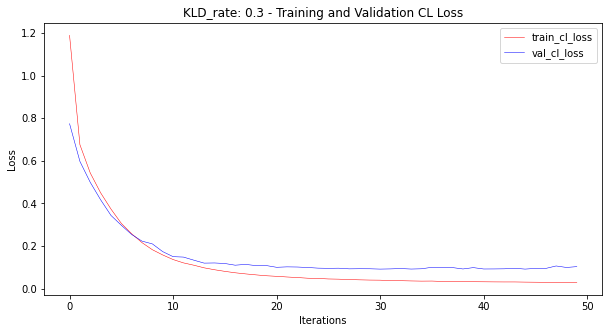

In [ ]:
plt.figure(figsize=(10,5))
plt.title(f"KLD_rate: {KLD_rate} - Training and Validation CL Loss")
plt.plot(train_CL, label="train_cl_loss", color='red', linewidth=0.5)
plt.plot(val_CL, label="val_cl_loss", color='blue', linewidth=0.5)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()

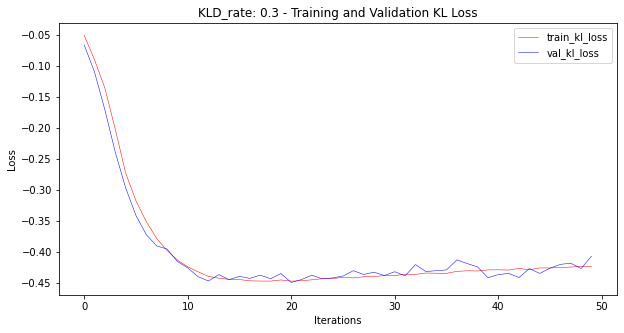

In [ ]:
plt.figure(figsize=(10,5))
plt.title(f"KLD_rate: {KLD_rate} - Training and Validation KL Loss")
plt.plot(train_KL, label="train_kl_loss", color='red', linewidth=0.5)
plt.plot(val_KL, label="val_kl_loss", color='blue', linewidth=0.5)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()

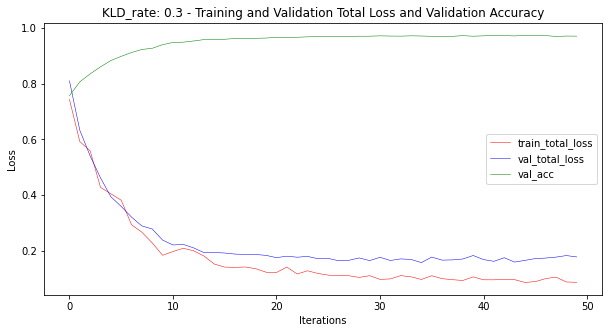

In [ ]:
plt.figure(figsize=(10,5))
plt.title(f"KLD_rate: {KLD_rate} - Training and Validation Total Loss and Validation Accuracy")
plt.plot(train_tot, label="train_total_loss", color='red', linewidth=0.5)
plt.plot(val_tot, label="val_total_loss", color='blue', linewidth=0.5)
plt.plot(val_acc, label="val_acc", color='green', linewidth=0.5)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()

In [ ]:
batch_size = 32
MolVAE = RNN_VAE().cuda()
ce_loss = nn.CrossEntropyLoss()

save_dir = 'VAE_Log/practice_VAE'
MolVAE.load_state_dict(torch.load(save_dir+'/MolVAE_'+str(48)+'.pth.tar'))


test_dataset = UserDataset('','data/Test_Smiles.txt')
testloader = DataLoader(test_dataset,batch_size=batch_size,shuffle=False)

print(f"Length of test dataset: {len(test_dataset)}")

count = 0
test_loss = []
test_acc = []
for inputs in tqdm(testloader):    # 100000
    Inds = Variable(inputs.view(-1,51).cuda())
    xout, _, _ = MolVAE(Inds[:,1:],Inds[:,:-1])
    CL = ce_loss(xout,Inds[:,1:].reshape(-1))
    test_loss.append(CL.item())
    xx = torch.argmax(xout,1).reshape(-1,50)
    ids = Inds[:,1:]
    accs = np.mean(torch.sum(xx==ids,1).cpu().detach().numpy())/50.0
    test_acc.append(accs.item())
    
print(f"\n\nTest Accuracy: {accs}")

100%|██████████| 4330/4330 [00:00<00:00, 91580.08it/s]


Length of test dataset: 4330


100%|██████████| 136/136 [00:01<00:00, 133.60it/s]



Test Accuracy: 0.956


In [ ]:
batch_size = 200
num_iter = 50

def Validity_Check():
    inputs = torch.randn(batch_size,256)
    xout = MolVAE.sampling(inputs)
    return xout

Gen_list = []
for itera in range(num_iter):
    x_out = Validity_Check()
    Gen_list.extend(x_out.tolist())

In [ ]:
# r_dict = {v:i for i,v in vocabulary.items()}
r_dict = {0: '[nH]', 1: 'o', 2: '[P@]', 3: 'n', 4: '5', 5: '[C@@H]', 6: 'Cl', 7: 's', 8: '[n+]',
          9: '[P@@]', 10: '\\', 11: 'Br', 12: 'F', 13: '[C@]', 14: ')', 15: '[o+]', 16: '3',
          17: '[C@@]', 18: '6', 19: '[n-]', 20: '[OH+]', 21: '[S-]', 22: '[N-]', 23: 'N',
          24: '[S@]', 25: '1', 26: '=', 27: '[nH+]', 28: 'I', 29: 'P', 30: '[S@@]', 31: 'c',
          32: 'S', 33: '[N+]', 34: '4', 35: '-', 36: '/', 37: '[NH3+]', 38: '2', 39: 'O',
          40: '[O-]', 41: '[NH+]', 42: '#', 43: '[PH2]', 44: 'C', 45: '[NH2+]', 46: '(', 47: '[C@H]', 48: '<', 49: '>'}

In [ ]:
smi_list = []

for token_smi in Gen_list:
    smiles = ''
    for info in token_smi:
        if r_dict[info] == '>':
            break
        smiles = smiles+r_dict[info]
    smi_list.append(smiles)

print(f"Number of generated moelcules : {len(smi_list)}")

Number of generated moelcules : 10000


In [ ]:
valid_smi, count = [], 0

for smi in smi_list:
    mol = Chem.MolFromSmiles(smi)
    if mol != None:
        valid_smi.append(smi)
        count += 1

print(f"Out of {len(smi_list)} generated moelcules only {count} are valid = {len(valid_smi)/len(smi_list) * 100}%")

Out of 10000 generated moelcules only 6984 are valid = 69.84%
